In [1]:
import os
# proxy = 'http://127.0.0.1:7890'
proxy = 'http://10.20.38.38:7890'
os.environ['http_proxy'] = proxy
os.environ['https_proxy'] = proxy
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import numpy as np
import torch
import sys
import random
from PIL import Image
from scipy.special import softmax
import open_clip
from mne.time_frequency import psd_array_multitaper
import torch.nn.functional as F
import torch.nn as nn
import random
from scipy.special import softmax
sys.path.append('/home/ldy/Closed_loop_optimizing')
from torchvision import transforms
from torchvision import models
from model.utils import load_model_encoder, generate_eeg, save_eeg_signal
import matplotlib.pyplot as plt
from model.custom_pipeline import Generator4Embeds
from model.modulation_utils import get_image_pool, load_target_psd, load_vlmodel

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/ldy/miniconda3/envs/BCI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ldy/miniconda3/envs/BCI/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/ldy/miniconda3/envs/BCI/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/ldy/miniconda3/envs/BCI/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pyt

In [2]:

fs = 250
selected_channel_idxes = [3, 4, 5]   # 'O1', 'Oz', 'O2'
# selected_channel_idxes = [range(17)]   # 'O1', 'Oz', 'O2'

model_type = 'ViT-H-14'

vlmodel, preprocess_train, feature_extractor = open_clip.create_model_and_transforms(
    model_type, pretrained='laion2b_s32b_b79k', precision='fp32', device = device)
vlmodel.to(device)

generator = Generator4Embeds(num_inference_steps=4, device=device)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.20it/s]
/home/ldy/miniconda3/envs/BCI/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
subject_id = 1
# base_save_path = f'/home/tjh/closed-loop/alexnet_without_pretrained/exp_sub{subject_id}/loop_random_{i}'
sub = 'sub-01'
model_path = f'/mnt/dataset0/jiahua/eeg_encoding/results/{sub}/synthetic_eeg_data/encoding-end_to_end/dnn-alexnet/modeled_time_points-all/pretrained-False/lr-1e-05__wd-0e+00__bs-064/model_state_dict.pt'
# target_eeg_path = f'/home/ldy/Closed_loop_optimizing/tjh/eeg_encoding/results/{sub}/synthetic_eeg_data/encoding-end_to_end/dnn-alexnet/modeled_time_points-all/pretrained-False/lr-1e-05__wd-0e+00__bs-064/gene_eeg/00183_tick_183.npy'
target_eeg_path = f'/home/ldy/Closed_loop_optimizing/tjh/eeg_encoding/results/{sub}/synthetic_eeg_data/encoding-end_to_end/dnn-alexnet/modeled_time_points-all/pretrained-False/lr-1e-05__wd-0e+00__bs-064/gene_eeg/00085_gondola_85.npy'

image_set_path = '/mnt/dataset0/ldy/4090_Workspace/4090_THINGS/images_set/test_images'

# target_image_path = '/mnt/dataset0/ldy/4090_Workspace/4090_THINGS/images_set/test_images/00183_tick/tick_06s.jpg'
target_image_path = '/mnt/dataset0/ldy/4090_Workspace/4090_THINGS/images_set/test_images/00085_gondola/gondola_11s.jpg'
save_path = "/home/ldy/Closed_loop_optimizing/outputs/heuristic_generation"
os.makedirs(save_path, exist_ok=True)

dir_name = os.path.basename(os.path.dirname(target_image_path))  # '00014_bike'



In [4]:
tar_psd_dir = f"/home/ldy/Closed_loop_optimizing/data/psd_feature/"
os.makedirs(tar_psd_dir, exist_ok = True)

file_path = os.path.join(tar_psd_dir, f"{dir_name}_psd.pt")

if os.path.exists(file_path):
    target_psd = torch.load(file_path).cpu()            
else:
    target_psd = load_target_psd(target_eeg_path, fs, selected_channel_idxes)
    torch.save(target_psd, file_path)
    print(f"Files {file_path} saved!")    


/tmp/ipykernel_1777078/528553668.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_psd = torch.load(file_path).cpu()


In [5]:
test_images_path, _ = get_image_pool(image_set_path, cache_file='/home/ldy/Closed_loop_optimizing/data/200_images/image_paths_cache.pkl')

test_images_path.remove(target_image_path)

Loading cached image paths from /home/ldy/Closed_loop_optimizing/data/200_images/image_paths_cache.pkl


In [6]:
def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor

def generate_eeg_from_image_paths(model_path, test_image_list, save_dir, device):
    synthetic_eegs = []
    model = load_model_encoder(model_path, device)
    for idx, image_path in enumerate(test_image_list):
        image_tensor = preprocess_image(image_path, device)
        synthetic_eeg = generate_eeg(model, image_tensor, device)
        synthetic_eegs.append(synthetic_eeg)

    return synthetic_eegs
        
def generate_eeg_from_image(model_path, images, save_dir, device):
    synthetic_eegs = []
    model = load_model_encoder(model_path, device)
    for idx, image in enumerate(images):
        image_tensor = preprocess_generated_image(image, device)
        synthetic_eeg = generate_eeg(model, image_tensor, device)
        synthetic_eegs.append(synthetic_eeg)
        # category = category_list[idx]
        # save_eeg_signal(synthetic_eeg, save_dir, idx, category)
    return synthetic_eegs

def preprocess_generated_image(image, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])    
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor

def calculate_loss_from_eeg_path(eeg_path, target_psd, fs, selected_channel_idxes):
    eeg = np.load(eeg_path, allow_pickle=True)
    selected_eeg = eeg[selected_channel_idxes, :]
    psd, _ = psd_array_multitaper(selected_eeg, fs, adaptive=True, normalization='full', verbose=0)
    psd = torch.from_numpy(psd.flatten()).unsqueeze(0)
    target_psd = torch.tensor(target_psd).view(1, 378)
    loss_fn = nn.MSELoss()
    loss = loss_fn(psd, target_psd)
    return loss

def calculate_loss(eeg, target_psd, fs, selected_channel_idxes):    
    selected_eeg = eeg[selected_channel_idxes, :]
    psd, _ = psd_array_multitaper(selected_eeg, fs, adaptive=True, normalization='full', verbose=0)
    psd = torch.from_numpy(psd.flatten()).unsqueeze(0)
    target_psd = torch.tensor(target_psd).view(1, 378)
    loss_fn = nn.MSELoss()
    loss = loss_fn(psd, target_psd)
    return loss

In [7]:
def reward_function_from_eeg_path(eeg_path, target_psd, fs, selected_channel_idxes):
    eeg = np.load(eeg_path, allow_pickle=True)
    selected_eeg = eeg[selected_channel_idxes, :]
    psd, _ = psd_array_multitaper(selected_eeg, fs, adaptive=True, normalization='full', verbose=0)
    psd = torch.from_numpy(psd.flatten()).unsqueeze(0)
    return F.cosine_similarity(target_psd, psd).item()


def reward_function(eeg, target_psd, fs, selected_channel_idxes):    
    selected_eeg = eeg[selected_channel_idxes, :]
    psd, _ = psd_array_multitaper(selected_eeg, fs, adaptive=True, normalization='full', verbose=0)
    psd = torch.from_numpy(psd.flatten()).unsqueeze(0)
    return F.cosine_similarity(target_psd, psd).item()


In [8]:

def fusion_image_to_images(chosen_images, device, save_path, scale):    
    with torch.no_grad():
        img_embeds = vlmodel.encode_image(torch.stack(chosen_images).to(device))
        
    embed1, embed2 = img_embeds[0].unsqueeze(0), img_embeds[1].unsqueeze(0)
    embed_len = embed1.size(1)
    start_idx = random.randint(0, embed_len - scale - 1)
    end_idx = start_idx + scale
    temp = embed1[:, start_idx:end_idx].clone()
    embed1[:, start_idx:end_idx] = embed2[:, start_idx:end_idx]
    embed2[:, start_idx:end_idx] = temp
    
    generated_images = []        
    with torch.no_grad():         
        image = generator.generate(embed1)
        generated_images.append(image)
        image = generator.generate(embed2)
        generated_images.append(image)
    torch.cuda.empty_cache()
    return generated_images
    

In [9]:
def select_from_image_paths(probabilities, similarities, losses, sample_image_paths, synthetic_eegs, device):
    chosen_indices = np.random.choice(len(probabilities), size=2, replace=False, p=probabilities)
    # print(f"sample_image_paths {len(sample_image_paths)}")
    # print(f"chosen_indices  {chosen_indices}")
    
    chosen_similarities = [similarities[idx] for idx in chosen_indices.tolist()] 
    chosen_losses = [losses[idx] for idx in chosen_indices.tolist()]    
    chosen_images = [Image.open(sample_image_paths[i]).convert("RGB") for i in chosen_indices.tolist()]        
    chosen_eegs = [synthetic_eegs[idx] for idx in chosen_indices.tolist()]
    return chosen_similarities, chosen_losses, chosen_images, chosen_eegs


def select_from_images(probabilities, similarities, losses, images_list, eeg_list):
    chosen_indices = np.random.choice(len(similarities), size=2, replace=False, p=probabilities)
    # print(f"eeg_list {len(eeg_list)}")
    # print(f"chosen_indices  {chosen_indices}")    
    chosen_similarities = [similarities[idx] for idx in chosen_indices.tolist()] 
    chosen_losses = [losses[idx] for idx in chosen_indices.tolist()]
    chosen_images = [images_list[idx] for idx in chosen_indices.tolist()]
    chosen_eegs = [eeg_list[idx] for idx in chosen_indices.tolist()]
    return chosen_similarities, chosen_losses, chosen_images, chosen_eegs


In [10]:

def get_prob_random_sample(test_images_path, model_path, save_path, fs, device, selected_channel_idxes, processed_paths, target_psd):
    available_paths = [path for path in test_images_path if path not in processed_paths]
    
    sample_image_paths = sorted(random.sample(available_paths, 10))
    
    processed_paths.update(sample_image_paths)
    sample_image_name = []
    for sample_image_path in sample_image_paths:
        filename = os.path.basename(sample_image_path).split('.')[0]
        sample_image_name.append(filename)    
    synthetic_eegs = generate_eeg_from_image_paths(model_path, sample_image_paths, save_path, device)
    
    similarities = []
    
    losses = []
    for eeg in synthetic_eegs:
        cs = reward_function(eeg, target_psd, fs, selected_channel_idxes)
        similarities.append(cs)
        loss = calculate_loss(eeg, target_psd, fs, selected_channel_idxes)
        losses.append(loss)
        
    probabilities = softmax(similarities)
    
    
    chosen_similarities, chosen_losses, chosen_images, chosen_eegs = select_from_image_paths(probabilities, similarities, losses, available_paths, synthetic_eegs, device)
    
    return chosen_similarities, chosen_losses, chosen_images, chosen_eegs

In [11]:

def visualize_top_images(images, similarities, save_folder, iteration):
    """
    使用 matplotlib 按相似度顺序显示选中的图片
    :param image_paths: 图片路径列表
    :param similarities: 每张图片的相似度列表
    """
    # 将图片路径和相似度结合，并按相似度降序排序
    image_similarity_pairs = sorted(zip(images, similarities), key=lambda x: x[1], reverse=True)
    
    # 拆分排序后的图片路径和相似度
    sorted_images, sorted_similarities = zip(*image_similarity_pairs)

    # 绘制图像
    fig, axes = plt.subplots(1, len(sorted_images), figsize=(15, 5))
    for i, image in enumerate(sorted_images):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Similarity: {sorted_similarities[i]:.4f}', fontsize=8)  # 显示相似度
    plt.show()
    
    os.makedirs(save_folder, exist_ok=True)  # 创建文件夹（如果不存在）
    save_path = os.path.join(save_folder, f"visualization_iteration_{iteration}.png")
    fig.savefig(save_path, bbox_inches='tight', dpi=300)  # 保存图像文件
    print(f"Visualization saved to {save_path}")

In [12]:
def compute_embed_similarity(img_feature, all_features):
    """
    计算某张图片与所有其他图片的余弦相似度
    :param img_feature: 选中图片的特征向量 [1024]
    :param all_features: 所有图片的特征向量 [2400, 1024]
    :return: 余弦相似度 [2400]
    """
    # 计算余弦相似度
    # distances = torch.norm(all_features - img_feature, dim=1)
    # cos_sim = torch.nn.functional.cosine_similarity(img_feature, all_features, dim=1)
    # # cos_sim = F.softmax(cos_sim, dim=0)
    dot_product = torch.matmul(all_features, img_feature)
    # cos_sim = (cos_sim + 1) / 2
    return dot_product

/tmp/ipykernel_1777078/1497327150.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_embeds = torch.load("/mnt/dataset1/ldy/Workspace/FLORA/data_preparing/ViT-H-14_fea

Created new experiment directory: /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/exp36
Loop 1/10


/home/ldy/miniconda3/envs/BCI/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ldy/miniconda3/envs/BCI/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/ldy/Closed_loop_optimizing/model/utils.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/b

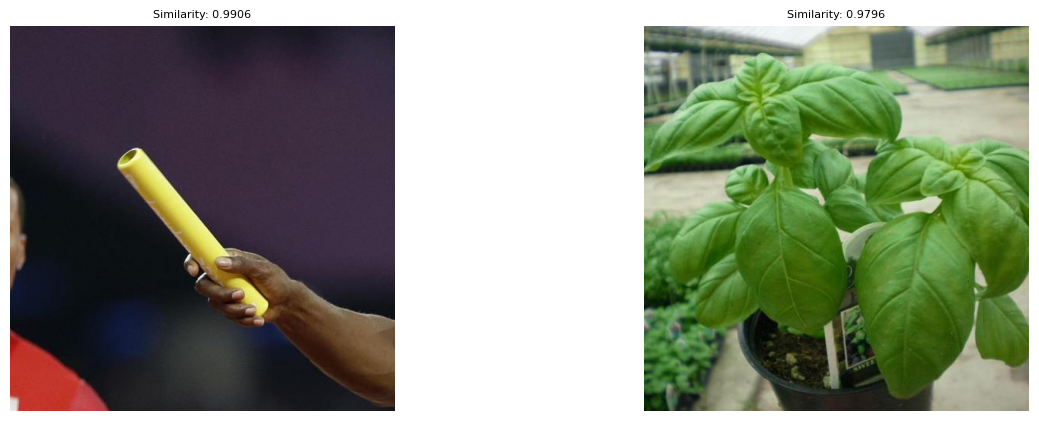

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_0.png
Loop 2/10


  0%|          | 0/4 [00:00<?, ?it/s]/home/ldy/miniconda3/envs/BCI/lib/python3.12/site-packages/diffusers/models/embeddings.py:1540: FutureWarning: You have passed a tensor as `image_embeds`.This is deprecated and will be removed in a future release. Please make sure to update your script to pass `image_embeds` as a list of tensors to suppress this warning.
  deprecate("image_embeds not a list", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 4/4 [00:00<00:00, 20.09it/s]


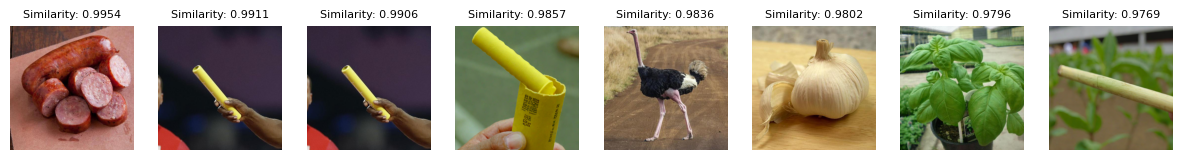

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_198.png
Loop 3/10


100%|██████████| 4/4 [00:00<00:00, 20.40it/s]


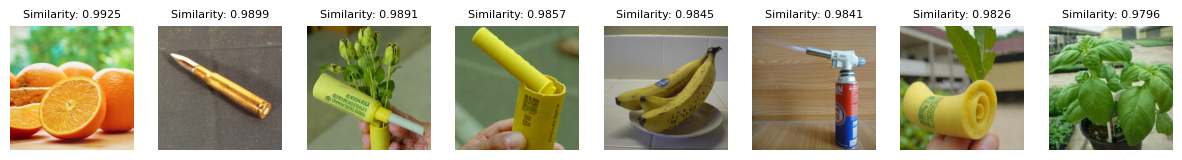

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_198.png
Loop 4/10


100%|██████████| 4/4 [00:00<00:00, 20.37it/s]


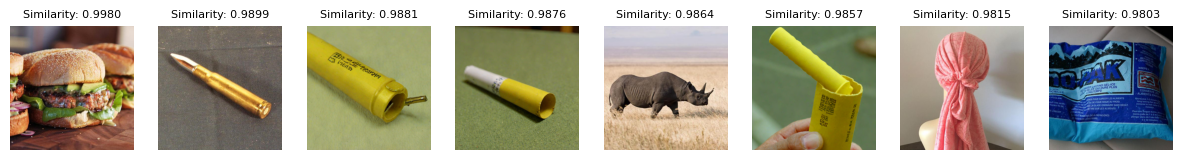

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_198.png
Loop 5/10


100%|██████████| 4/4 [00:00<00:00, 20.39it/s]


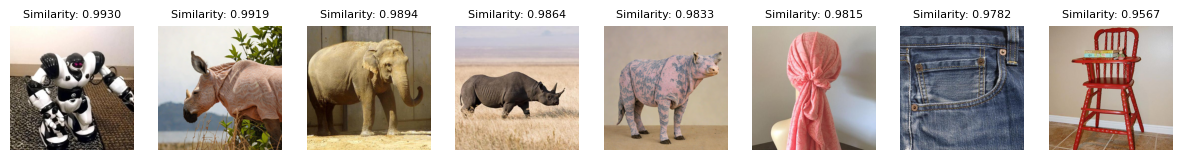

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_198.png
0.9930190075196514 0.9906358052236944 0.00238320229595701
Loop 6/10


100%|██████████| 4/4 [00:00<00:00, 18.93it/s]


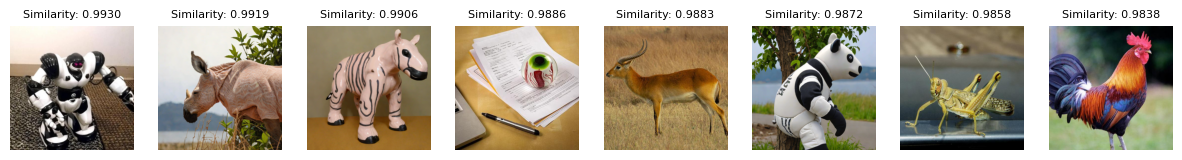

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_198.png
Loop 7/10


100%|██████████| 4/4 [00:00<00:00, 20.43it/s]


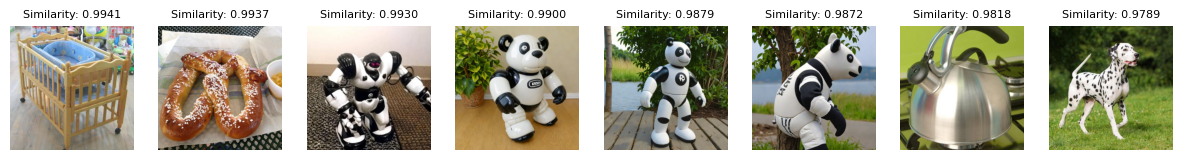

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_198.png
0.9937046721552851 0.9930190075196514 0.0006856646356336871
Loop 8/10


100%|██████████| 4/4 [00:00<00:00, 20.22it/s]


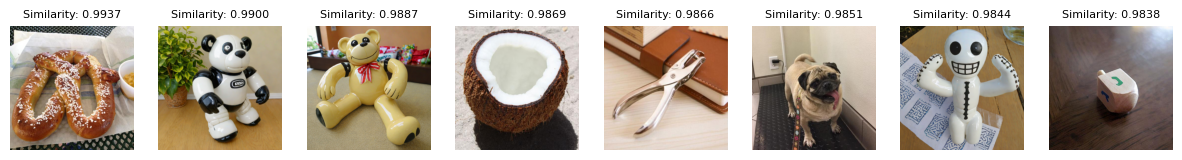

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_198.png
Loop 9/10


100%|██████████| 4/4 [00:00<00:00, 20.38it/s]


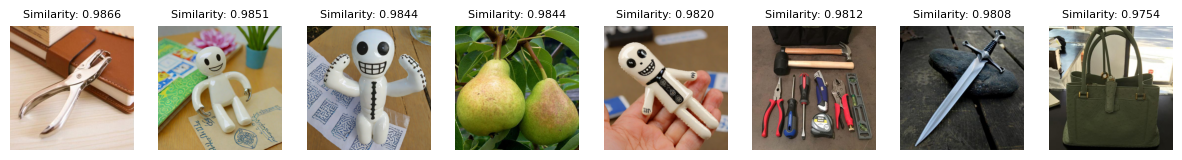

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_198.png
Loop 10/10


100%|██████████| 4/4 [00:00<00:00, 20.46it/s]


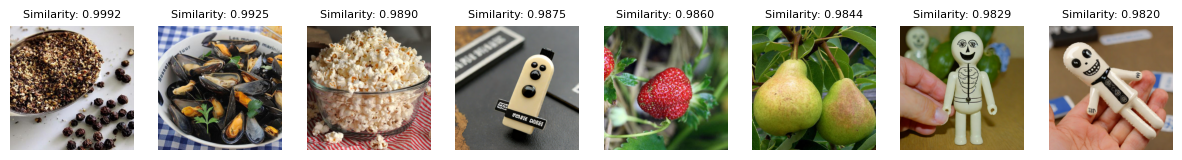

Visualization saved to /home/ldy/Closed_loop_optimizing/outputs/heuristic_generation/visualization_iteration_198.png


In [13]:
num_loops = 10

processed_paths = set()

all_chosen_rewards = []
all_chosen_losses = []
all_chosen_images = []
all_chosen_eegs = []

history_cs = []
history_loss = []
fit_images = []
fit_eegs = []
fit_rewards = []
fit_losses = []
save_folder = f'/home/ldy/Closed_loop_optimizing/outputs/heuristic_generation'
plots_save_folder = '/home/ldy/Closed_loop_optimizing/plots/Interactive_search'
img_embeds = torch.load("/mnt/dataset1/ldy/Workspace/FLORA/data_preparing/ViT-H-14_features_test.pt")['img_features'].cpu()

# 确保基础目录存在
os.makedirs(save_folder, exist_ok=True)
# 查找已存在的实验目录
existing_exps = [d for d in os.listdir(save_folder) if d.startswith('exp') and d[3:].isdigit()]
if existing_exps:
    # 获取最大的实验编号
    max_num = max(int(exp[3:]) for exp in existing_exps)
    new_exp_num = max_num + 1
else:
    # 如果没有已存在的实验，从1开始
    new_exp_num = 1
# 创建新实验目录
new_exp_dir = os.path.join(save_folder, f'exp{new_exp_num}')
os.makedirs(new_exp_dir, exist_ok=True)
print(f"Created new experiment directory: {new_exp_dir}")

for i in range(num_loops):
    print(f"Loop {i + 1}/{num_loops}")
    round_save_path = os.path.join(save_path, f'loop{i + 1}')
    loop_sample_ten = []
    loop_reward_ten = []
    loop_eeg_ten = []
    loop_loss_ten = []
    os.makedirs(save_path, exist_ok=True)

    if i == 0:
        first_ten = os.path.join(round_save_path, 'first_ten')
        os.makedirs(first_ten, exist_ok=True)
        chosen_rewards, chosen_losses, chosen_images, chosen_eegs = get_prob_random_sample(test_images_path, 
                                                                                    model_path, 
                                                                                    first_ten, 
                                                                                    fs, device, 
                                                                                    selected_channel_idxes,
                                                                                    processed_paths, 
                                                                                    target_psd)
        
        loop_sample_ten.extend(chosen_images)
        loop_eeg_ten.extend(chosen_eegs)
        loop_reward_ten.extend(chosen_rewards)
        loop_loss_ten.extend(chosen_losses)
                
    else:                            
        loop_sample_ten.extend(fit_images)
        loop_eeg_ten.extend(fit_eegs)
        loop_reward_ten.extend(fit_rewards)
        loop_loss_ten.extend(fit_losses)
        
        tensor_fit_images = [preprocess_train(i) for i in fit_images]        
        generated_images = fusion_image_to_images(tensor_fit_images, device, round_save_path, 512)                            
        synthetic_eegs = generate_eeg_from_image(model_path, generated_images, round_save_path, device)        
        
        loop_sample_ten.extend(generated_images)
        loop_eeg_ten.extend(synthetic_eegs)
                
        for eeg in synthetic_eegs:        
            cs = reward_function(eeg, target_psd, fs, selected_channel_idxes)
            loss = calculate_loss(eeg, target_psd, fs, selected_channel_idxes)
            loop_reward_ten.append(cs)
            loop_loss_ten.append(loss)    
        

        greedy_images = []
        with torch.no_grad():
            loop_img_embeds = vlmodel.encode_image(torch.stack([preprocess_train(i) for i in loop_sample_ten]).to(device))
        for img_embed in loop_img_embeds:      
            available_indices = []
            available_paths = []            
            for i, path in enumerate(test_images_path):
                if path not in processed_paths:
                    available_indices.append(i)
                    available_paths.append(path)
            
            sample_image_paths =[]            
            available_features = img_embeds[available_indices]
                        
            cosine_similarities = compute_embed_similarity(img_embed, available_features.to(device))     
            sorted_available_indices = np.argsort(cosine_similarities.cpu())
            top_indices = sorted_available_indices[-1]
            greedy_image = Image.open(available_paths[top_indices]).convert("RGB")
            greedy_images.append(greedy_image)
            sample_image_paths.append(available_paths[top_indices])
                
            processed_paths.update(sample_image_paths)    
            
        synthetic_eegs = generate_eeg_from_image(model_path, greedy_images, round_save_path, device)            
        
        loop_sample_ten.extend(greedy_images)
        loop_eeg_ten.extend(synthetic_eegs)
                
        for eeg in synthetic_eegs:        
            cs = reward_function(eeg, target_psd, fs, selected_channel_idxes)
            loss = calculate_loss(eeg, target_psd, fs, selected_channel_idxes)
            loop_reward_ten.append(cs)
            loop_loss_ten.append(loss)        
        

        loop_probabilities = softmax(loop_reward_ten)    
        chosen_rewards, chosen_losses, chosen_images, chosen_eegs = select_from_images(loop_probabilities, loop_reward_ten, loop_loss_ten, loop_sample_ten, loop_eeg_ten)        
        
        # 将四个列表按照chosen_rewards的值从大到小排序
        combined = list(zip(chosen_rewards, chosen_losses, chosen_images, chosen_eegs))
        combined.sort(reverse=True, key=lambda x: x[0])  # 按rewards降序排列

        # 解压排序后的数据
        chosen_rewards, chosen_losses, chosen_images, chosen_eegs = zip(*combined)

        # 如果需要将结果转回列表（因为zip返回的是元组）
        chosen_rewards = list(chosen_rewards)
        chosen_losses = list(chosen_losses)
        chosen_images = list(chosen_images)
        chosen_eegs = list(chosen_eegs)


    fit_images = chosen_images
    fit_eegs = chosen_eegs
    fit_rewards = chosen_rewards
    fit_losses = chosen_losses
    
                
    all_chosen_rewards.extend(chosen_rewards)
    all_chosen_losses.extend(chosen_losses)
    all_chosen_images.extend(chosen_images)
    all_chosen_eegs.extend(chosen_eegs)
    
    # print(f"chosen_images {len(chosen_images)}")
    # print(f"chosen_rewards {len(chosen_rewards)}")        
    visualize_top_images(loop_sample_ten, loop_reward_ten, save_folder, i)

    max_similarity = max(chosen_rewards)
    
    max_index = chosen_rewards.index(max_similarity)
    corresponding_loss = chosen_losses[max_index]
    

    if len(history_cs) == 0:
        history_cs.append(max_similarity)
        history_loss.append(corresponding_loss) 
    else:
        max_history = max(history_cs)
        if max_similarity > max_history:
            history_cs.append(max_similarity)
            history_loss.append(corresponding_loss)
        else:
            history_cs.append(max_history)
            history_loss.append(history_loss[-1])

    if len(history_cs) >= 2:
        if history_cs[-1] != history_cs[-2]:
            diff = abs(history_cs[-1] - history_cs[-2])
            print(history_cs[-1], history_cs[-2], diff)
            if diff <= 1e-4:
                print("The difference is within 10e-4, stopping.")
                break



chosen_rewards 2
all_chosen_losses 20
all_chosen_images 20
all_chosen_eegs 20


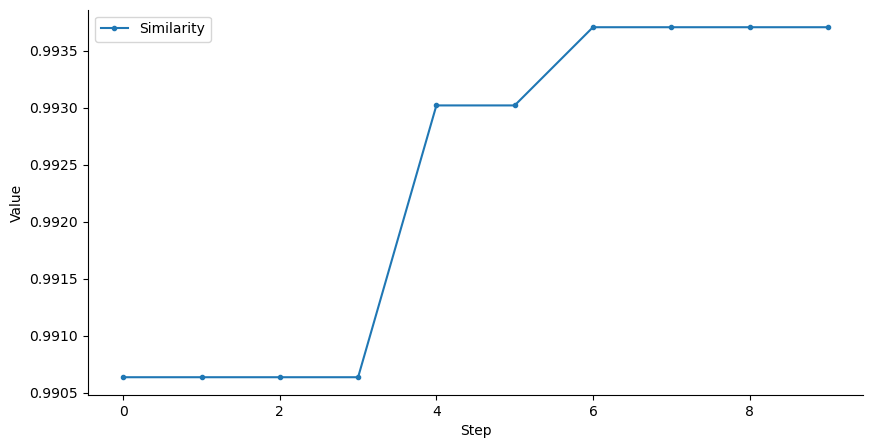

In [14]:
print(f"chosen_rewards {len(chosen_rewards)}")
print(f"all_chosen_losses {len(all_chosen_losses)}")
print(f"all_chosen_images {len(all_chosen_images)}")
print(f"all_chosen_eegs {len(all_chosen_eegs)}")

plt.figure(figsize=(10, 5))
plt.plot(history_cs, marker='o', markersize=3, label='Similarity')
# plt.plot(history_cs, marker='o', markersize=5, label='Similarity')
# plt.plot(history_loss, marker='x', markersize=3, label='Loss')
plt.xlabel('Step')
plt.ylabel('Value')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend() 
path = os.path.join(save_path, 'similarities.jpg')
plt.savefig(path)
plt.show()


In [15]:
# num_run = 1
# num_subjects = 7
# for subject_id in range(1, 2):
#     base_seed = 100000 * subject_id 
#     for i in range(1, num_run + 1):
#         # base_save_path = f'/home/tjh/closed-loop/alexnet_without_pretrained/exp_sub{subject_id}/loop_random_{i}'
#         base_save_path = f'/mnt/dataset0/kyw/closed-loop/alexnet_without_pretrained/exp_sub{subject_id}/loop_random_{i}'
#         os.makedirs(base_save_path, exist_ok=True)
#         seed = base_seed + i 
#         np.random.seed(seed)
#         random.seed(seed)
#         print(f'Subject {subject_id}/{num_subjects} - Run {i}/{num_run} - Seed: {seed}')
#         main_experiment_loop(seed, subject_id, base_save_path)
